## Objective is to design the following network and learn how to reshape(to get the same dimentions) and add two layers(skip connections) 
![](enas.png)

In [1]:
#importing the libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.regularizers import l2
from keras.layers import Input, SeparableConv2D, Conv1D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout ,Concatenate, DepthwiseConv2D , Add, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
import tensorflow as tf

Using TensorFlow backend.


## Data preparation

In [0]:
#load the cifar10 dataset from keras
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()#split the data set into train and test
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))#get the number of classes

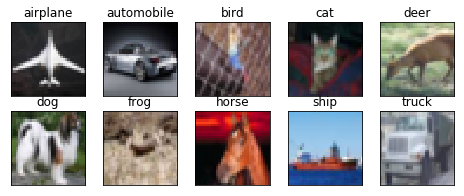

In [3]:
#get class name
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    #plot the images.
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot model's history
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#convert to 'float32' and divide by 255 to scale it in [0,1]
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def add_skip_conn(layers = []):
  """[Adds the given layers in the list and apply ReLu to it,provided their dimensions are same]
    
    Keyword Arguments:
        layers {list} -- [list of layers to be added using Add()] 
  """
  return Activation('relu')(Add()(layers))



In [0]:
def reshape(x, block_size):
    """[Rearranges blocks of spatial data, into depth.]
    
    Arguments:
        x {[tensor]} -- [layer to be reshaped]
        block_size {[int]} -- [ input block size]
    
    Returns:
        [tensor] -- [Rearranged blocks of spatial data, into depth]
    """
    return tf.nn.space_to_depth(x, block_size)

In [0]:
def seprable_convolution(input_layer, num_filters, k_size, padding='same'):
    """[Creates seprable convolutions,apply activation,Batchnormalization and dropout to it. ]

      Arguments:
          input_layer {[tensor]} -- [layer on which is input to current convolution]
          num_filters {[int]} -- [number of filters]
          k_size {[int]} -- [kernel size]

      Keyword Arguments:
          padding {str} -- [padding to be applied] (default: {'same'})
    """
    conv = SeparableConv2D(num_filters, (k_size, 1),
                           padding='same')(input_layer)
    conv = SeparableConv2D(num_filters, (1, k_size), padding='same')(conv)
    conv = Activation('relu')(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.1)(conv)

    return conv

In [0]:
def normal_convolution(input_layer,num_filters,k_size,padding='same'):
    """[Creates 2d convolutions,apply activation,Batchnormalization and dropout to it. ]
    
    Arguments:
        input_layer {[tensor]} -- [layer on which is input to current convolution]
        num_filters {[int]} -- [number of filters]
        k_size {[int]} -- [kernel size]
    
    Keyword Arguments:
        padding {str} -- [padding to be applied] (default: {'same'})
   """
    conv=Convolution2D(num_filters,(k_size,k_size),padding='same')(input_layer)
    conv=Activation('relu')(conv)
    conv=BatchNormalization()(conv)
    conv=Dropout(0.1)(conv)
    
    return conv

##  Model

In [11]:
input_=Input(train_features.shape[1:])

conv1=seprable_convolution(input_,8,5)


conv2=normal_convolution(conv1,8,5)


conv3=normal_convolution(conv2,8,5)

add1 = add_skip_conn([conv1, conv3])

conv4=seprable_convolution(add1,8,5)

add2=add_skip_conn([conv4, conv1])



max1=MaxPooling2D(pool_size=(2, 2))(add2)


conv5=seprable_convolution(max1,32,3)

re1= Lambda(reshape,arguments = {'block_size' : 2})(conv1)
re2=Lambda(reshape,arguments = {'block_size' : 2})(conv4)

add3=add_skip_conn([conv5, re1])

conv6=normal_convolution(add3,32,5)


conv7=seprable_convolution(conv6,32,3)


add4=add_skip_conn([conv5, conv7])

conv8=seprable_convolution(add4,32,5)

add5=add_skip_conn([conv8, conv7,re1,re2])

max2=MaxPooling2D(pool_size=(2, 2))(add5)

conv9=normal_convolution(max2,128,1)


re3=Lambda(reshape,arguments = {'block_size' : 2})(conv6)


add6=add_skip_conn([conv9, re3])


conv10=normal_convolution(add6,128,5)

re4=Lambda(reshape,arguments = {'block_size' : 4})(conv2)
re5=Lambda(reshape,arguments = {'block_size' : 2})(conv7)
re6=Lambda(reshape,arguments = {'block_size' : 4})(conv1)
re7=Lambda(reshape,arguments = {'block_size' : 4})(conv3)
re8=Lambda(reshape,arguments = {'block_size' : 2})(conv5)
re9=Lambda(reshape,arguments = {'block_size' : 4})(conv4)




add7=add_skip_conn([conv10, re4,re5,re6])

conv11=seprable_convolution(add7,128,5)

add8=add_skip_conn([conv10, conv11,re4,re7,re8])

conv12=normal_convolution(add8,128,3)



add9=add_skip_conn([conv11,conv12,re7,re5,re8])


conv13=seprable_convolution(add9,128,5)

add10=add_skip_conn([conv13,conv11,re9,re5])

conv14=normal_convolution(add10,10,1)




gap1 = GlobalAveragePooling2D()(conv14)
softmax = Activation('softmax')(gap1)

model = Model(inputs = input_, outputs = softmax)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<class 'tensorflow.python.framework.ops.Tensor'>



In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 8)    47          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 32, 32, 8)    112         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 8)    0           separable_conv2d_2[0][0]         
____________________________________________________________________________________________

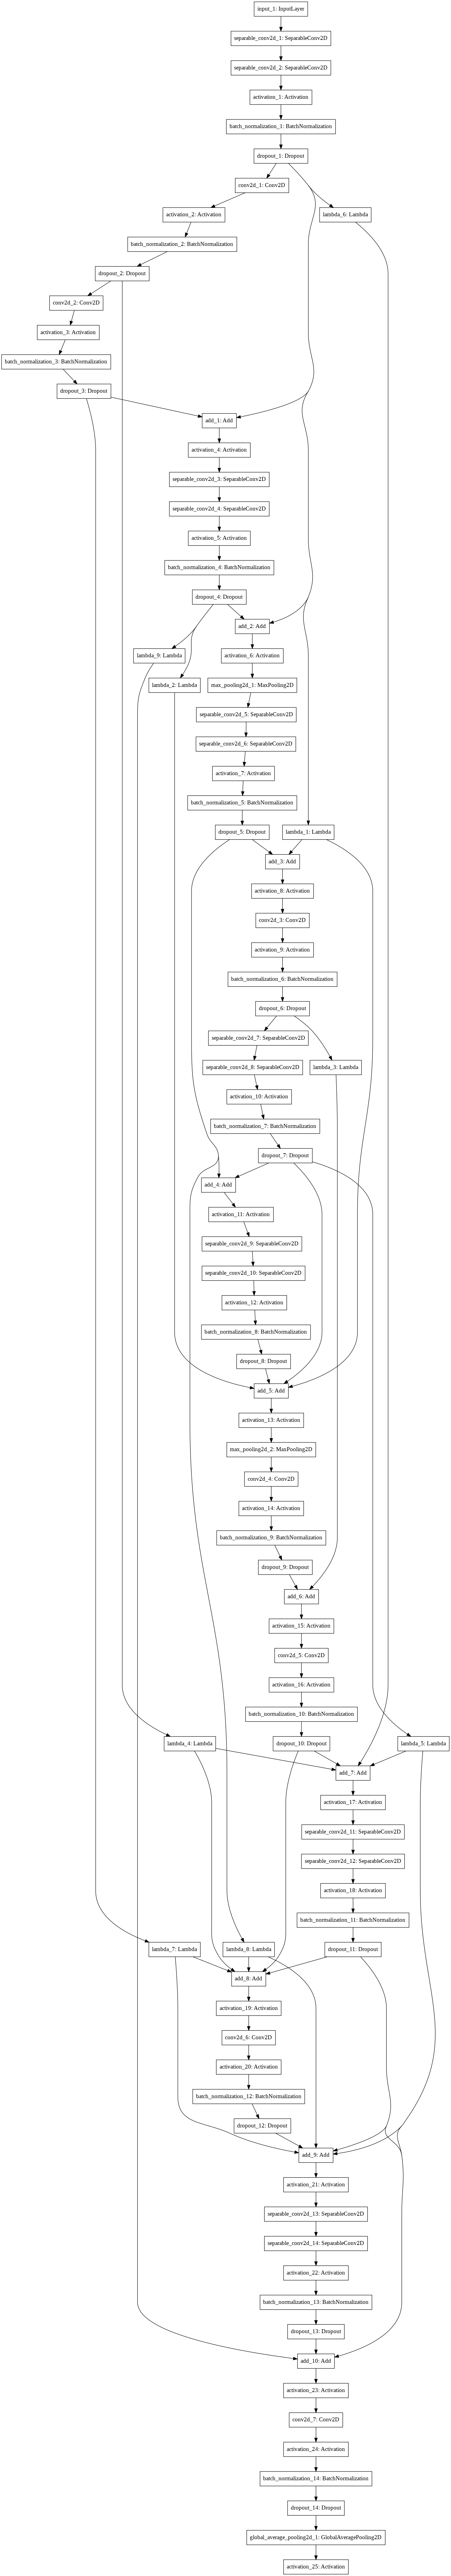

In [13]:
plot_model(model,to_file='multilayer_perceptron_graph.png')

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 1000, nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`




Epoch 1/50
1000/1000 [==============================] - 130s 130ms/step - loss: 1.3351 - acc: 0.5410 - val_loss: 1.2413 - val_acc: 0.5896

Epoch 00001: val_acc improved from -inf to 0.58960, saving model to best_model.hdf5
Epoch 2/50
1000/1000 [==============================] - 122s 122ms/step - loss: 0.9184 - acc: 0.6892 - val_loss: 0.8900 - val_acc: 0.7043

Epoch 00002: val_acc improved from 0.58960 to 0.70430, saving model to best_model.hdf5
Epoch 3/50
1000/1000 [==============================] - 122s 122ms/step - loss: 0.7671 - acc: 0.7390 - val_loss: 1.1119 - val_acc: 0.6678

Epoch 00003: val_acc did not improve from 0.70430
Epoch 4/50
1000/1000 [==============================] - 122s 122ms/step - loss: 0.6695 - acc: 0.7723 - val_loss: 0.7688 - val_acc: 0.7420

Epoch 00004: val_acc improved from 0.70430 to 0.74200, saving model to best_model.hdf5
Epoch 5/50
1000/1000 [==============================] - 122s 122ms/step - loss: 0.6056 - acc: 0.7933 - val_loss: 0.7523 - val_acc: 0.7

In [16]:
model.load_weights('./best_model.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 84.10


**We can clearly see that our model is overfitting and need to be regularized.**